In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt 
from sklearn.metrics import r2_score
from statsmodels.nonparametric.kernel_density import EstimatorSettings

from modules.RegressionGraph import RegressionGraph, build_reggraph_by_r_script
from modules.ICERegression import ICERegression

%load_ext autoreload
%autoreload 2

## Simulated example

Context variables based on a predetermined concentration matrix-

In [2]:
ss=1000

mean = [0,0,0,0]
concen =   [[ 2, -1,  0,  0],
            [-1,  2, -1,  0],
            [ 0, -1,  2, -1],
            [ 0,  0, -1,  2]]

conv=np.linalg.inv(concen)

print(conv)

print(np.linalg.cholesky(conv))

[[0.8 0.6 0.4 0.2]
 [0.6 1.2 0.8 0.4]
 [0.4 0.8 1.2 0.6]
 [0.2 0.4 0.6 0.8]]
[[0.89442719 0.         0.         0.        ]
 [0.67082039 0.8660254  0.         0.        ]
 [0.4472136  0.57735027 0.81649658 0.        ]
 [0.2236068  0.28867513 0.40824829 0.70710678]]


Generating the responses:

In [3]:
simdat2 = pd.DataFrame(np.random.multivariate_normal(mean, conv, size=ss),
                       columns=['X5', 'X6', 'X7', 'X8'])

def M4_5(X):
    return X**2

simdat2['X4'] = M4_5(simdat2['X5']) + np.random.normal(loc=0, scale=1, size=ss)

def M3_8(X):
    return X**3

simdat2['X3'] = M3_8(simdat2['X8']) + np.random.normal(loc=0, scale=1, size=ss)

def M2_67(X, Z):
    return X*Z

simdat2['X2'] = M2_67(simdat2['X6'], simdat2['X7']) + np.random.normal(loc=0, scale=1, size=ss)

def M1_234(X, Z, W):
    return X+Z+W

simdat2['X1'] = M1_234(simdat2['X2'], simdat2['X3'], simdat2['X4']) + np.random.normal(loc=0, scale=1, size=ss)

simdat2.head()

,X5,X6,X7,X8,X4,X3,X2,X1
0,0.173691,-0.319029,1.710767,1.683581,-0.058890,4.445110,-1.423465,3.377602
1,-1.223279,-0.021655,0.668543,1.464969,1.269543,4.638583,-0.152853,6.556583
2,0.718671,0.532402,0.524097,0.195514,0.016996,0.360115,-0.343352,-0.052866
3,0.837295,0.517535,-0.779633,-0.531374,0.005941,-1.477899,0.583655,-0.944023
4,1.562072,1.399292,-0.148510,0.394338,3.452091,-0.476114,-1.060356,2.492376


Learn the graph from the data, trough the gRchain R script.

In [4]:
learnt_g = build_reggraph_by_r_script(simdat2,
                                        boxes={'context':['X5', 'X6', 'X7', 'X8'],
                                                'interm':['X2', 'X3', 'X4'],
                                                'output':['X1']})[0]

X1~X2+X3+X4~X5+X6+X7+X8
    X1  X2  X3  X4  X5  X6  X7  X8
X1   0   0   0   0   0   0   0   0
X2   1   0   1   0   0   0   0   0
X3   1   0   0   0   0   0   0   0
X4   1   0   1   0   0   0   0   0
X5   0   0   0   1   0   1   0   0
X6   0   1   0   0   1   0   1   0
X7   0   1   1   0   0   1   0   1
X8   0   0   1   0   0   0   1   0


Providing our own graph instead:

In [5]:
simulg=RegressionGraph(incoming_digraph={'X4':['X5'],
                                            'X3':['X8'],
                                            'X2':['X6', 'X7'],
                                            'X1':['X2', 'X3', 'X4'],
                                           'X5':[],
                                           'X6':[],
                                           'X7':[]},
                       incoming_ungraph=[('X5','X6'),('X6','X7'),('X7','X8')],
                        types={'X1':'c','X2':'c','X3':'c','X4':'c',
                                'X5':'c','X6':'c','X7':'c','X8':'c'},
                        boxes={'context':['X5', 'X6', 'X7', 'X8'],
                                'interm':['X2', 'X3', 'X4'],
                                'output':['X1']},
                        reversed_input=True)

Drawing and saving the graphs.

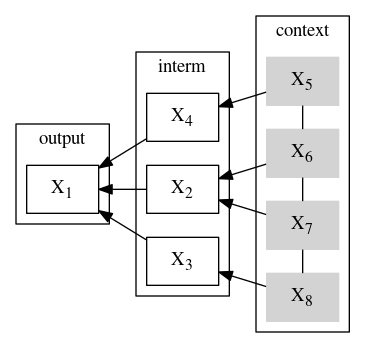

In [6]:
labels={'X1':'<X<SUB>1</SUB>>',
       'X2':'<X<SUB>2</SUB>>',
       'X3':'<X<SUB>3</SUB>>',
       'X4':'<X<SUB>4</SUB>>',
       'X5':'<X<SUB>5</SUB>>',
       'X6':'<X<SUB>6</SUB>>',
       'X7':'<X<SUB>7</SUB>>',
       'X8':'<X<SUB>8</SUB>>'}
simulg.draw_it(labels=labels)


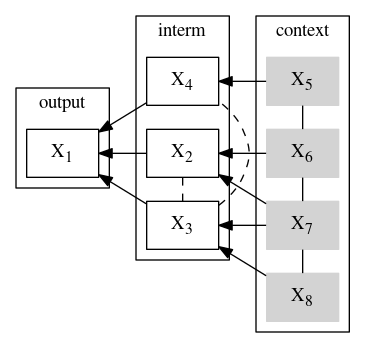

In [7]:

learnt_g.draw_it(labels=labels)

In [9]:
simulg.save_it('tmp/simul_graph.pdf', labels=labels, format='pdf')

## ICE regression model

Model fiting.

In [8]:
mod=ICERegression(simulg)
mod.fit(simdat2)


Parameters of X4 are learned.
Parameters of X3 are learned.
Parameters of X2 are learned.
Parameters of X1 are learned.


Prediction based on the context variables.

In [9]:
X_pred = mod.predict(simdat2[['X5', 'X6', 'X7', 'X8']], traindata=simdat2, plot_steps=False)
X_pred.head()

['X8']
['X6', 'X7']
['X5']
['X2', 'X3', 'X4']


,X5,X6,X7,X8,X3,X2,X4,X1
0,0.173691,-0.319029,1.710767,1.683581,4.049851,-0.563186,0.089342,2.880724
1,-1.223279,-0.021655,0.668543,1.464969,2.696100,0.062776,1.459886,3.156290
2,0.718671,0.532402,0.524097,0.195514,0.088505,0.354825,0.486387,0.869276
3,0.837295,0.517535,-0.779633,-0.531374,-0.197006,-0.117321,0.648076,0.494529
4,1.562072,1.399292,-0.148510,0.394338,0.154558,-0.089465,2.199360,2.197121


Export/import the trained model.

In [10]:
jp_out = open("tmp/simulICE.jspkl","w")
jp_out.write(mod.serialize())
jp_out.close()

In [11]:
jp_out = open("tmp/simulICE.jspkl","r")
jspkl_str = jp_out.read()
mod_ds = ICERegression.deserialize(jspkl_str)
jp_out.close()

In [12]:
for i in mod_ds.models.keys():
    np.testing.assert_allclose(mod_ds.models[i].fitted_model.data, mod.models[i].fitted_model.data)

In [13]:
X_pred2 = mod_ds.predict(simdat2[['X5', 'X6', 'X7', 'X8']], traindata=simdat2, plot_steps=False)
X_pred2.head()

['X8']
['X6', 'X7']
['X5']
['X2', 'X3', 'X4']


,X5,X6,X7,X8,X3,X2,X4,X1
0,0.173691,-0.319029,1.710767,1.683581,4.049851,-0.563186,0.089342,2.880724
1,-1.223279,-0.021655,0.668543,1.464969,2.696100,0.062776,1.459886,3.156290
2,0.718671,0.532402,0.524097,0.195514,0.088505,0.354825,0.486387,0.869276
3,0.837295,0.517535,-0.779633,-0.531374,-0.197006,-0.117321,0.648076,0.494529
4,1.562072,1.399292,-0.148510,0.394338,0.154558,-0.089465,2.199360,2.197121


In [14]:
for i in X_pred.columns:
    np.testing.assert_allclose(X_pred[i], X_pred2[i], rtol=1e-07)
    print(i, " is the same")

X5  is the same
X6  is the same
X7  is the same
X8  is the same
X3  is the same
X2  is the same
X4  is the same
X1  is the same


## Plots, evaluatian

2D plots of the data, the theoretical regression, and the smoothings.

<ipython-input-18-1211856c7ba2>:58: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('tmp/bigsimplot.pdf', dpi=150, bbox_inches='tight', frameon=False)


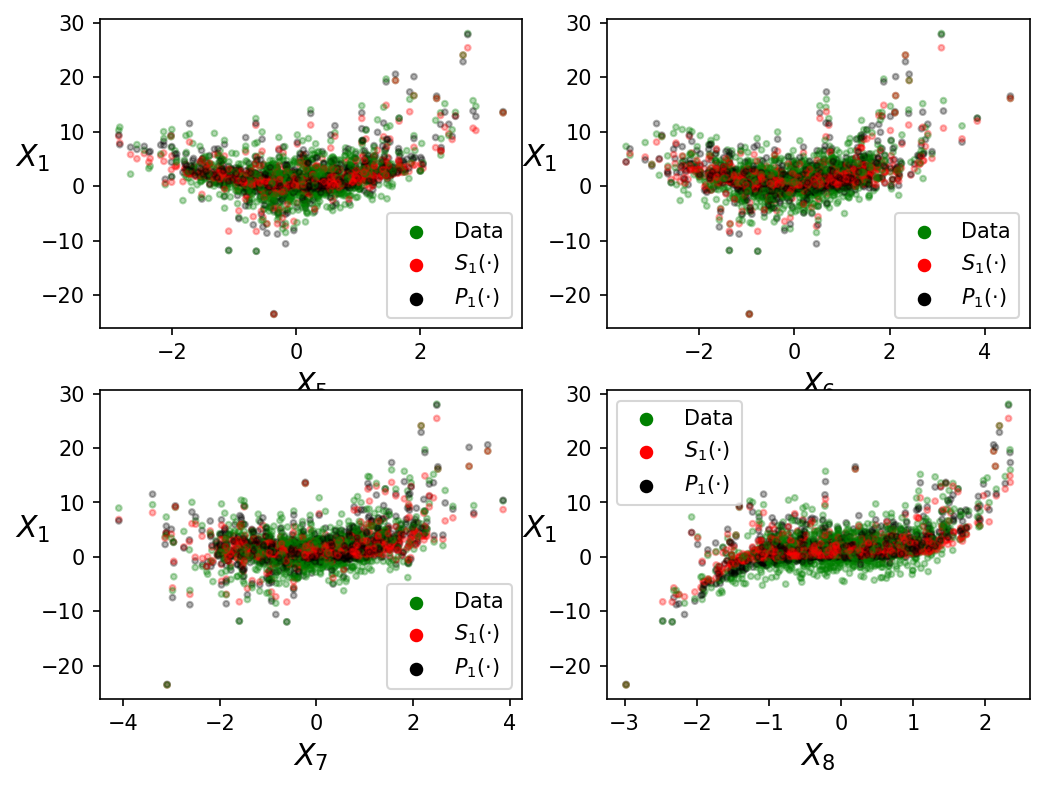

In [18]:
colors={'Data':'green', '$S_1(\cdot)$':'red', '$P_1(\cdot)$':'black'}

def merginnng(x, ys, colors):
    data_df = pd.concat([x, ys[0]], axis=1)
    smoo_df = pd.concat([x, ys[1]], axis=1)
    regr_df = pd.concat([x, ys[2]], axis=1)
    list_df= [data_df, smoo_df, regr_df]
    for i in list_df:
        i.rename(columns={list(i)[0]: 'X', list(i)[1]: 'Y'}, inplace=True)
        # print(list(i))
    big_df = pd.concat([data_df, smoo_df, regr_df], axis=0, 
                       keys=colors.keys())
    return big_df.sample(frac=1.)


def plllot(df, colors, xlab, ylab, fs1='x-large', fs2='medium', ms=30, alp=.3):
    plt.scatter(df['X'], df['Y'], c=pd.Series(bigg.index.get_level_values(0)).apply(lambda x: colors[x]),
                s=ms, alpha=alp, marker='.', rasterized=True)
    for k, v in colors.items():
        plt.scatter([], [], c=v, alpha=1, s=ms, label=k)
    plt.xlabel(xlab, fontsize=fs1)
    plt.ylabel(ylab, fontsize=fs1, rotation=0)
    plt.legend(fontsize=fs2)
    return True

plt.figure(figsize=(8,6), dpi=150)
#colors={'data':'red', 'smoo':'blue', 'regr':'black'}

plt.subplot(221)
bigg=merginnng(simdat2['X5'],
               [simdat2['X1'],
                X_pred['X1'],
               M1_234(M4_5(simdat2['X5']), M3_8(simdat2['X8']), M2_67(simdat2['X6'], simdat2['X7']))], colors)
plllot(bigg, colors, '$X_5$', '$X_1$')
               
plt.subplot(222)
bigg=merginnng(simdat2['X6'],
               [simdat2['X1'],
                X_pred['X1'],
               M1_234(M4_5(simdat2['X5']), M3_8(simdat2['X8']), M2_67(simdat2['X6'], simdat2['X7']))], colors)
plllot(bigg, colors, '$X_6$', '$X_1$')

plt.subplot(223)
bigg=merginnng(simdat2['X7'],
               [simdat2['X1'],
                X_pred['X1'],
               M1_234(M4_5(simdat2['X5']), M3_8(simdat2['X8']), M2_67(simdat2['X6'], simdat2['X7']))], colors)
plllot(bigg, colors, '$X_7$', '$X_1$')

plt.subplot(224)
bigg=merginnng(simdat2['X8'],
               [simdat2['X1'],
                X_pred['X1'],
               M1_234(M4_5(simdat2['X5']), M3_8(simdat2['X8']), M2_67(simdat2['X6'], simdat2['X7']))], colors)
plllot(bigg, colors, '$X_8$', '$X_1$')


plt.savefig('tmp/bigsimplot.pdf', dpi=150, bbox_inches='tight', frameon=False)

plt.show()


3D plots

<ipython-input-20-1e4b28c2cb2e>:44: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('tmp/bigsimplot3d.pdf', bbox_inches='tight', frameon=False)


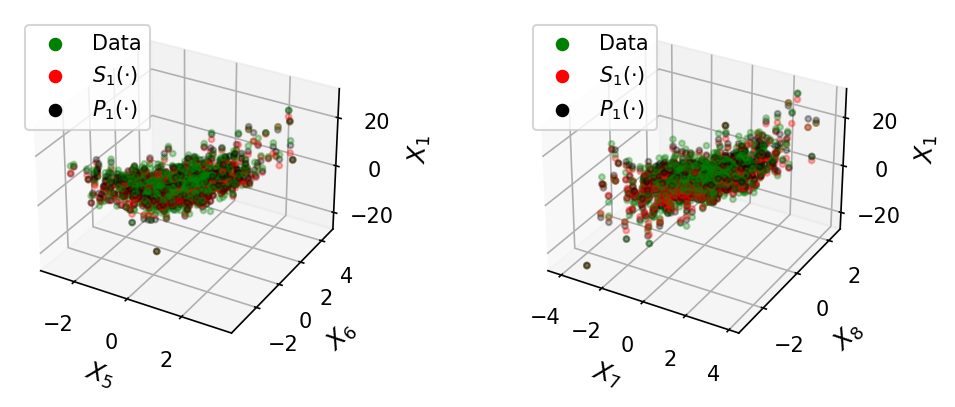

In [20]:
from mpl_toolkits.mplot3d import Axes3D 
colors={'Data':'green', '$S_1(\cdot)$':'red', '$P_1(\cdot)$':'black'}

def merginnng3d(x, y, zs, colors):
    data_df = pd.concat([x, y, zs[0]], axis=1)
    smoo_df = pd.concat([x, y, zs[1]], axis=1)
    regr_df = pd.concat([x, y, zs[2]], axis=1)
    list_df= [data_df, smoo_df, regr_df]
    for i in list_df:
        i.rename(columns={list(i)[0]: 'X', list(i)[1]: 'Y', list(i)[2]: 'Z'}, inplace=True)
        # print(list(i))
    big_df = pd.concat([data_df, smoo_df, regr_df], axis=0, 
                       keys=colors.keys())
    return big_df.sample(frac=1.)


def plllot3d(df, colors, subp, xlab, ylab, zlab, fs1='large', fs2='medium', ms=30, alp=.3):
    ax = fig.add_subplot(subp, projection='3d')
    ax.scatter(df['X'], df['Y'], df['Z'], c=pd.Series(bigg.index.get_level_values(0)).apply(lambda x: colors[x]),
                s=ms, alpha=alp, marker='.', rasterized=True)
    for k, v in colors.items():
        ax.scatter([], [], [], c=v, alpha=1, s=ms, label=k)
    ax.set_xlabel(xlab, fontsize=fs1, rotation=0)
    ax.set_ylabel(ylab, fontsize=fs1, rotation=0)
    ax.set_zlabel(zlab, fontsize=fs1, rotation=90)
    plt.legend(fontsize=fs2)
    return True


fig=plt.figure(figsize=(8,3), dpi=150)

bigg=merginnng3d(simdat2['X5'], simdat2['X6'],
               [simdat2['X1'],
                X_pred['X1'],
               M1_234(M4_5(simdat2['X5']), M3_8(simdat2['X8']), M2_67(simdat2['X6'], simdat2['X7']))], colors)
plllot3d(bigg, colors, 121, '$X_5$', '$X_6$', '$X_1$')

bigg=merginnng3d(simdat2['X7'], simdat2['X8'],
               [simdat2['X1'],
                X_pred['X1'],
               M1_234(M4_5(simdat2['X5']), M3_8(simdat2['X8']), M2_67(simdat2['X6'], simdat2['X7']))], colors)
plllot3d(bigg, colors, 122, '$X_7$', '$X_8$', '$X_1$')

plt.savefig('tmp/bigsimplot3d.pdf', bbox_inches='tight', frameon=False)

plt.show()


Different metrics

In [22]:
r2_score(simdat2['X1'], X_pred['X1'])

0.6883554736794469

In [23]:
r2_score(M1_234(X_pred['X2'], X_pred['X3'], X_pred['X4']), X_pred['X1'])

0.9601389301780366

In [24]:
r2_score(M1_234(M4_5(simdat2['X5']), M3_8(simdat2['X8']), M2_67(simdat2['X6'], simdat2['X7'])), X_pred['X1'])

0.9281998035806972

In [26]:
numsim=pd.DataFrame()

def mse_r2(Y, Yhat):
    Y_bar = np.mean(Yhat)
    R2_numer = (((Y - Y_bar) * (Yhat - Y_bar)).sum(axis=0))**2
    R2_denom = ((Y - Y_bar)**2).sum(axis=0) * ((Yhat - Y_bar)**2).sum(axis=0)
    R2 = R2_numer / R2_denom
    #MSE = ((Y - Yhat)**2).sum(axis=0)/Y.size
    MSE = np.mean((Y - Yhat)**2)
    return MSE, R2


# MSE, R2 = mse_r2(simdat2['X1'], X_pred2['X1'])

# numsim.loc['$X_1$','$MSE_{scott}$']=np.around(MSE, 3)
# numsim.loc['$X_1$','$R^2_{scott}$']=np.around(R2, 3)

# MSE, R2 = mse_r2(M1_234(M4_5(simdat2['X5']), M3_8(simdat2['X8']), M2_67(simdat2['X6'], simdat2['X7'])),
#                  X_pred2['X1'])

# numsim.loc['$P_1(\cdot)$','$MSE_{scott}$']=np.around(MSE, 3)
# numsim.loc['$P_1(\cdot)$','$R^2_{scott}$']=np.around(R2, 3)


MSE, R2 = mse_r2(simdat2['X1'], X_pred['X1'])

numsim.loc['$X_1$','$MSE_{cv}$']=np.around(MSE, 3)
numsim.loc['$X_1$','$R^2_{cv}$']=np.around(R2, 3)

MSE, R2 = mse_r2(M1_234(M4_5(simdat2['X5']), M3_8(simdat2['X8']), M2_67(simdat2['X6'], simdat2['X7'])),
                 X_pred['X1'])

numsim.loc['$P_1(\cdot)$','$MSE_{cv}$']=np.around(MSE, 3)
numsim.loc['$P_1(\cdot)$','$R^2_{cv}$']=np.around(R2, 3)


numsim.to_latex(buf='tmp/simul_nums.tex', escape=False)

numsim

,$MSE_{cv}$,$R^2_{cv}$
$X_1$,4.642,0.715
$P_1(\cdot)$,0.784,0.962


# Dashed line example
Testing if the nodes in the same box (connected based on cond. cov.) are needed in the regression or not. 

Data gen., where X5 will serve as a known/unkown confounder depending on the trained model.

In [2]:
ss=1000
mean = [0,0,0]
concen =   [[ 2, -1,  0],
            [-1,  2, -1],
            [ 0, -1,  2]]

conv=np.linalg.inv(concen)

print(conv)

print(np.linalg.cholesky(conv))

[[0.75 0.5  0.25]
 [0.5  1.   0.5 ]
 [0.25 0.5  0.75]]
[[0.8660254  0.         0.        ]
 [0.57735027 0.81649658 0.        ]
 [0.28867513 0.40824829 0.70710678]]


In [3]:
simdat3 = pd.DataFrame(np.random.multivariate_normal(mean, conv, size=ss),
                       columns=['X4','X5', 'X6'])

def M3_56(X, Z):
    return X**3 + Z

simdat3['X3'] = M3_56(simdat3['X5'], simdat3['X6']) + np.random.normal(loc=0, scale=1, size=ss)

def M2_45(X, Z):
    return X - Z**2 +1

simdat3['X2'] = M2_45(simdat3['X4'], simdat3['X5']) + np.random.normal(loc=0, scale=1, size=ss)

def M1_23(X, Z):
    return np.sin(X)+Z

simdat3['X1'] = M1_23(simdat3['X2'], simdat3['X3']) + np.random.normal(loc=0, scale=1, size=ss)

simdat3.head()

,X4,X5,X6,X3,X2,X1
0,-0.087392,1.268180,0.369637,0.512630,-0.942103,0.505736
1,-1.400904,-2.786989,-1.104614,-23.396499,-7.352934,-23.207127
2,-0.018553,0.359824,0.856275,1.829246,2.990022,1.104958
3,-0.318579,-1.767967,-0.897263,-6.737768,-2.897697,-4.642490
4,0.119208,-0.106401,0.871250,2.180578,1.182315,2.536518


### X5 is known (ideal case)

In [4]:
simulg3a=RegressionGraph(incoming_digraph={'X3':['X5', 'X6'],
                                            'X2':['X4', 'X5'],
                                            'X1':['X2', 'X3'],
                                           'X5':[],
                                           'X6':[]},
                        types={'X1':'c','X2':'c','X3':'c','X4':'c',
                                'X5':'c','X6':'c'},
                        boxes={'context':['X4', 'X5', 'X6'],
                                'interm':['X2', 'X3'],
                                'output':['X1']},
                        reversed_input=True)

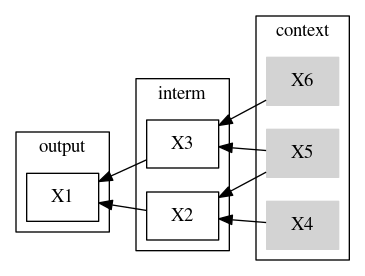

In [5]:
simulg3a.draw_it()

In [6]:
mod3a=ICERegression(simulg3a)
mod3a.fit(simdat3)
X_pred3a = mod3a.predict(simdat3[['X4', 'X5', 'X6']], plot_steps=False)

Parameters of X3 are learned.
Parameters of X2 are learned.
Parameters of X1 are learned.
['X4', 'X5']
['X5', 'X6']
['X2', 'X3']


### X5 is unknown 
X2 and X3 are connected because of this

In [7]:
simulg3b=RegressionGraph(incoming_digraph={'X3':['X2', 'X6'],
                                            'X2':['X3','X4'],
                                            'X1':['X2', 'X3'],
                                           'X6':[]},
                        types={'X1':'c','X2':'c','X3':'c','X4':'c','X6':'c'},
                        boxes={'context':['X4', 'X6'],
                                'interm':['X2', 'X3'],
                                'output':['X1']},
                        reversed_input=True)

In [8]:
simulg3b.undirected.nodes

NodeView(('X3', 'X2', 'X1', 'X6', 'X4'))

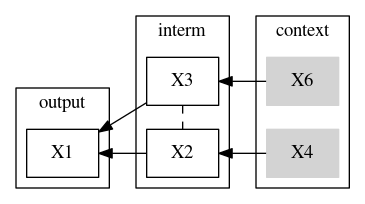

In [9]:
simulg3b.draw_it()

Training a model where X3 is used as a regressor of X2.

In [10]:
mod3b=ICERegression(simulg3b, boxparents=True)
mod3b.fit(simdat3[[f'X{i}' for i in range(1,7) if i !=5]])
X_pred3b = mod3b.predict(simdat3[['X4', 'X6']], plot_steps=False)

Parameters of X3 are learned.
Parameters of X2 are learned.
Parameters of X1 are learned.
['X6']
['X3', 'X4']
['X2', 'X3']


In [11]:
mod3b

/home/baranyim/miniconda3/envs/ICE/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


('X3', {'box': 'interm', 'type': 'c'})
('X2', {'box': 'interm', 'type': 'c'})
('X1', {'box': 'output', 'type': 'c'})
('X6', {'box': 'context', 'type': 'c'})
('X4', {'box': 'context', 'type': 'c'})
model of X3
KernelRegWrapper(bw=array([0.22939728], dtype=float32), var_type='c',
                 y_type=None)
model of X2
KernelRegWrapper(bw=array([1.5031502 , 0.27691555], dtype=float32),
                 var_type='cc', y_type=None)
model of X1
KernelRegWrapper(bw=array([0.65037894, 1.5031502 ], dtype=float32),
                 var_type='cc', y_type=None)

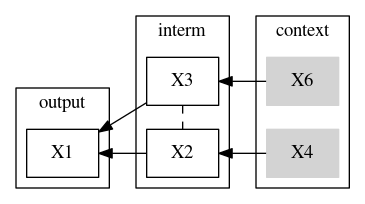

In [25]:
mod3b.reggraph.draw_it()

In [16]:
mod3b.reggraph.directed.edges()

OutEdgeView([('X3', 'X1'), ('X3', 'X2'), ('X2', 'X1'), ('X6', 'X3'), ('X4', 'X2')])

Training without X3 as regressor for X2.

In [18]:
mod3c=ICERegression(simulg3b, boxparents=False)
mod3c.fit(simdat3[[f'X{i}' for i in range(1,7) if i !=5]])
X_pred3c = mod3c.predict(simdat3[['X4', 'X6']], plot_steps=False)

Parameters of X3 are learned.
Parameters of X2 are learned.
Parameters of X1 are learned.
['X6']
['X4']
['X2', 'X3']


In [19]:
mod3c

('X3', {'box': 'interm', 'type': 'c'})
('X2', {'box': 'interm', 'type': 'c'})
('X1', {'box': 'output', 'type': 'c'})
('X6', {'box': 'context', 'type': 'c'})
('X4', {'box': 'context', 'type': 'c'})
model of X3
KernelRegWrapper(bw=array([0.22939728], dtype=float32), var_type='c',
                 y_type=None)
model of X2
KernelRegWrapper(bw=array([0.21996184], dtype=float32), var_type='c',
                 y_type=None)
model of X1
KernelRegWrapper(bw=array([0.65037894, 1.5031502 ], dtype=float32),
                 var_type='cc', y_type=None)

Plots, evaluation

X3 has no additional information in the regression of X2.

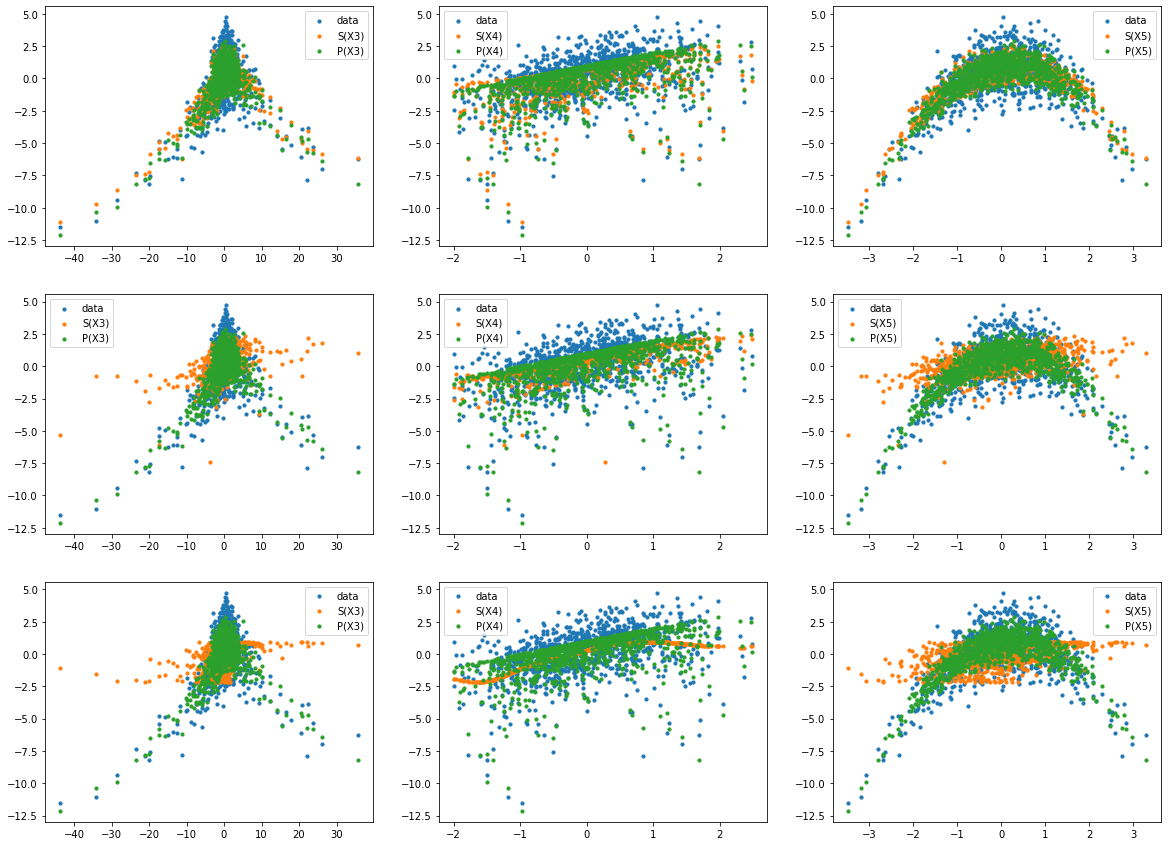

In [20]:
ms=10
alp=1
plt.figure(figsize=(20,15))

plt.subplot(331)
plt.scatter(simdat3['X3'], simdat3['X2'], s=ms, label='data', alpha=alp)
plt.scatter(simdat3['X3'], X_pred3a['X2'], s=ms, label='S(X3)', alpha=alp)
plt.scatter(simdat3['X3'], M2_45(simdat3['X4'], simdat3['X5']),
                                 s=ms, label='P(X3)', alpha=alp)
#plt.scatter(simdat2['X1'], m32(simdat2['X2']), s=ms, label='reg over reg over data')
plt.legend()

plt.subplot(332)
plt.scatter(simdat3['X4'], simdat3['X2'], s=ms, label='data', alpha=alp)
plt.scatter(simdat3['X4'], X_pred3a['X2'], s=ms, label='S(X4)', alpha=alp)
plt.scatter(simdat3['X4'], M2_45(simdat3['X4'], simdat3['X5']),
                                 s=ms, label='P(X4)', alpha=alp)
#plt.scatter(simdat2['X1'], m32(simdat2['X2']), s=ms, label='reg over reg over data')
plt.legend()

plt.subplot(333)
plt.scatter(simdat3['X5'], simdat3['X2'], s=ms, label='data', alpha=alp)
plt.scatter(simdat3['X5'], X_pred3a['X2'], s=ms, label='S(X5)', alpha=alp)
plt.scatter(simdat3['X5'], M2_45(simdat3['X4'], simdat3['X5']),
                                 s=ms, label='P(X5)', alpha=alp)
#plt.scatter(simdat2['X1'], m32(simdat2['X2']), s=ms, label='reg over reg over data')
plt.legend()

plt.subplot(334)
plt.scatter(simdat3['X3'], simdat3['X2'], s=ms, label='data', alpha=alp)
plt.scatter(simdat3['X3'], X_pred3b['X2'], s=ms, label='S(X3)', alpha=alp)
plt.scatter(simdat3['X3'], M2_45(simdat3['X4'], simdat3['X5']),
                                 s=ms, label='P(X3)', alpha=alp)
#plt.scatter(simdat2['X1'], m32(simdat2['X2']), s=ms, label='reg over reg over data')
plt.legend()

plt.subplot(335)
plt.scatter(simdat3['X4'], simdat3['X2'], s=ms, label='data', alpha=alp)
plt.scatter(simdat3['X4'], X_pred3b['X2'], s=ms, label='S(X4)', alpha=alp)
plt.scatter(simdat3['X4'], M2_45(simdat3['X4'], simdat3['X5']),
                                 s=ms, label='P(X4)', alpha=alp)
#plt.scatter(simdat2['X1'], m32(simdat2['X2']), s=ms, label='reg over reg over data')
plt.legend()

plt.subplot(336)
plt.scatter(simdat3['X5'], simdat3['X2'], s=ms, label='data', alpha=alp)
plt.scatter(simdat3['X5'], X_pred3b['X2'], s=ms, label='S(X5)', alpha=alp)
plt.scatter(simdat3['X5'], M2_45(simdat3['X4'], simdat3['X5']),
                                 s=ms, label='P(X5)', alpha=alp)
#plt.scatter(simdat2['X1'], m32(simdat2['X2']), s=ms, label='reg over reg over data')
plt.legend()

plt.subplot(337)
plt.scatter(simdat3['X3'], simdat3['X2'], s=ms, label='data', alpha=alp)
plt.scatter(simdat3['X3'], X_pred3c['X2'], s=ms, label='S(X3)', alpha=alp)
plt.scatter(simdat3['X3'], M2_45(simdat3['X4'], simdat3['X5']),
                                 s=ms, label='P(X3)', alpha=alp)
#plt.scatter(simdat2['X1'], m32(simdat2['X2']), s=ms, label='reg over reg over data')
plt.legend()

plt.subplot(338)
plt.scatter(simdat3['X4'], simdat3['X2'], s=ms, label='data', alpha=alp)
plt.scatter(simdat3['X4'], X_pred3c['X2'], s=ms, label='S(X4)', alpha=alp)
plt.scatter(simdat3['X4'], M2_45(simdat3['X4'], simdat3['X5']),
                                 s=ms, label='P(X4)', alpha=alp)
#plt.scatter(simdat2['X1'], m32(simdat2['X2']), s=ms, label='reg over reg over data')
plt.legend()

plt.subplot(339)
plt.scatter(simdat3['X5'], simdat3['X2'], s=ms, label='data', alpha=alp)
plt.scatter(simdat3['X5'], X_pred3c['X2'], s=ms, label='S(X5)', alpha=alp)
plt.scatter(simdat3['X5'], M2_45(simdat3['X4'], simdat3['X5']),
                                 s=ms, label='P(X5)', alpha=alp)
#plt.scatter(simdat2['X1'], m32(simdat2['X2']), s=ms, label='reg over reg over data')
plt.legend()

#plt.savefig(figplace+'bigsimplot.png', dpi=150, bbox_inches='tight', frameon=False)

plt.show()

$R^2$ on X2

In [21]:
print(
    r2_score(simdat3['X2'], X_pred3a['X2']),
    r2_score(simdat3['X2'], X_pred3b['X2']),
    r2_score(simdat3['X2'], X_pred3c['X2']))

0.7152084122102351 0.2272743170534267 0.22544086302926725


In [22]:
print(
    r2_score(M2_45(simdat3['X4'], simdat3['X5']), X_pred3a['X2']),
    r2_score(M2_45(simdat3['X4'], simdat3['X5']), X_pred3b['X2']),
    r2_score(M2_45(simdat3['X4'], simdat3['X5']), X_pred3c['X2']))

0.9768911182108542 0.3144127075504656 0.3139425900175221


$R^2$ on X1

In [23]:
print(
    r2_score(simdat3['X1'], X_pred3a['X1']),
    r2_score(simdat3['X1'], X_pred3b['X1']),
    r2_score(simdat3['X1'], X_pred3c['X1']))

0.8592580491566892 0.32930373494788834 0.33446636018189924


In [24]:
print(
    r2_score(M1_23(M2_45(simdat3['X4'], simdat3['X5']),M3_56(simdat3['X5'], simdat3['X6'])), X_pred3a['X1']),
    r2_score(M1_23(M2_45(simdat3['X4'], simdat3['X5']),M3_56(simdat3['X5'], simdat3['X6'])), X_pred3b['X1']),
    r2_score(M1_23(M2_45(simdat3['X4'], simdat3['X5']),M3_56(simdat3['X5'], simdat3['X6'])), X_pred3c['X1']))

0.9578642254672155 0.37965200996440507 0.3801225266182572
